# Propensity to Convert ML Model Training

In this notebook we will be using sample behavioral data collected by Snowplow's Javascript tracker from Snowplow's [website](https://snowplow.io/). Using this data we will build a model to predict if a user is likely to become a Snowplow customer.

### Model Selection

Boosting trees often perform better than neural networks on categorical data sets, such as this one. The most popular ones are XGBoost, LightGBM and CatBoost, each with different strengths. For this example we will use LightGBM.

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency
* Lower memory usage
* Better accuracy
* Support of parallel, distributed, and GPU learning
* Capable of handling large-scale data


**Resources:**
- [Full LightGBM Documentation](https://lightgbm.readthedocs.io/en/v3.3.2/)

### Configuration

* Python 3.8
* Install Snowpark for Python and other libraries to your environment, if using Anaconda run the following to create a virtual environment with all the packages needed:
  * `conda create --name snowpark --override-channels -c https://repo.anaconda.com/pkgs/snowflake python=3.8 numpy pandas dill scikit-learn cachetools lightgbm notebook snowflake-snowpark-python matplotlib plotly`
  * `conda activate snowpark`
  * `pip install imblearn`
* Add a `connection.json` file to your directory with your Snowflake account details and credentials ([view template](https://github.com/snowplow/composable-cdp-with-predictive-ml-modeling-accelerator/blob/main/content/predictive_ml_models/static/connection.json))
* [Snowpark-optimized warehouses](https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized) are recommended if your ML training has large memory requirements

In [1]:
from snowflake.snowpark import Session
import json
import os
import pandas as pd
import lightgbm as lgb
import numpy as np
import dill
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, make_scorer
from sklearn.pipeline import Pipeline

In [2]:
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()

### Prepare dataset for training

In [3]:
user_features = session.table('FIRST_TOUCH_USER_FEATURES')
df = pd.DataFrame(user_features.collect())
df.columns = map(str.lower, df.columns)

ref_cols = ["refr_urlhost", "refr_medium"]
mkt_cols = ["mkt_medium", "mkt_source", "mkt_term"]
geo_cols = ["geo_country", "geo_region", "br_lang"]
dev_cols = ["device_family", "os_family"]
url_cols = ["first_page_title"]
engagement_cols = ["engaged_time_in_s", "absolute_time_in_s", "vertical_percentage_scrolled"]

discrete_col = ref_cols + mkt_cols + geo_cols + dev_cols + url_cols
continues_col = engagement_cols
all_features = discrete_col + continues_col

# Input missing data
for col in discrete_col:
    df[col].fillna("N/A", inplace=True)
for col in continues_col:
    df[col].fillna(df[col].mean(), inplace=True)

df.head()

,user_id,first_page_title,refr_urlhost,refr_medium,mkt_medium,mkt_source,mkt_term,mkt_campaign,engaged_time_in_s,absolute_time_in_s,vertical_percentage_scrolled,geo_country,geo_region,br_lang,device_family,os_family,converted_user
0,000276b605066680a7fa83509a64bc91,Snowplow: behavioral data creation leader,N/A,N/A,N/A,N/A,N/A,None,15,0,9.0,US,NY,en-US,Mac,Mac OS X,False
1,00094b5d7449bd89425fc6dede800b55,Get started with your Snowplow BDP demo | Snow...,www.linkedin.com,social,N/A,N/A,N/A,None,75,9,36.0,TR,34,tr-TR,Mac,Mac OS X,True
2,0019dcde87bed9be2034269bc764e7dd,White paper: Introductory guide to data modeli...,www.google.com,search,ppc,google-ad,data modelers,data-modeling,0,0,19.0,US,TX,en-US,iPhone,iOS,False
3,0021c59a8c518b055a4a28813181b3cc,September Product Office Hours | Snowplow,N/A,N/A,N/A,N/A,N/A,None,20,30,22.0,BE,VAN,nl-NL,Mac,Mac OS X,False
4,0024241b2e79ebd0d0566a23c011aed3,Snowplow: behavioral data creation leader,www.facebook.com,social,N/A,N/A,N/A,None,5,21,28.0,US,N/A,en-US,Other,Linux,False


In [4]:
print(f"Users: {len(df)}")
print(df["converted_user"].value_counts(normalize=True))

Users: 9106
False    0.936416
True     0.063584
Name: converted_user, dtype: float64


The provided training data is relatively small in size and combined with a low conversion rate, we consider it to be imbalanced. Therefore we will balance the dataset with SMOTE, which will oversample the data by introducing new synthetic converted user samples.

In [5]:
# Reduce number of categorical features so `SMOTENC` doesn't run out of memory. 
class TakeTopK(BaseEstimator, TransformerMixin):
  def __init__(self, k=20):
    self.largest_cat = {}
    self.k = k

  def fit(self, X, y=None):
    for col in discrete_col:
      self.largest_cat[col] = df[col].value_counts().nlargest(self.k).index
    return self

  def transform(self, X, y=None):
    Xt = pd.DataFrame()
    for col in discrete_col:
      Xt[col] = pd.Series(np.where(X[col].isin(self.largest_cat[col]), X[col], 'Other'), dtype='category')
    Xt[continues_col] = X[continues_col].astype(float)
    return Xt

In [6]:
# Create train and test data sets
cat_index = [ pd.Index(all_features).get_loc(col) for col in discrete_col ]
df_train, df_test = df.iloc[:df.shape[0]//10*8,:], df.iloc[df.shape[0]//10*8:,:]
smote_nc = SMOTENC(categorical_features=cat_index, k_neighbors=5,  random_state=0)
topk = TakeTopK(50)
X_res, y_res = smote_nc.fit_resample(topk.fit_transform(df_train[all_features]), df_train.converted_user)


### Hyperparameter tuning
Using GridSearchCV to run a hyperparameter sweep to train multiple models in parallel.

Before fitting model hyperparameters, it is essential to establish what model property is being maximized. Accuracy would not work for this data due to class imbalance. A common approach to avoid this issue is the F1 score – a harmonic mean of precision and recall.

Identifying conversions (true positive) is more important than misclassifying negatives (false positives). Because F1 assigns the same weight to both precision and recall, it needs to be generalized to F Beta. That allows us to weight recall against precision. F2 (beta equals 2) is used for this example – recall is twice as important as precision. The value of beta should be tuned to a business case, for further information view [Wikipedia's entry for F-score](https://en.wikipedia.org/wiki/F-score).


In [7]:
lgbm = Pipeline([('top_20', TakeTopK(50)), ('clf', lgb.LGBMClassifier())])

search_space = {
  'clf__max_depth': [3, 4, 5, 6, 7],
  'clf__objective': ['binary'],
  'clf__metric': ['binary_logloss'],
  'clf__n_estimators': [10, 50, 100, 200],
  'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
  'clf__num_leaves': [20, 30],
  'clf__min_child_samples': [5, 10, 15]
}

scorer = make_scorer(fbeta_score, beta=2, pos_label=True)

gscv = GridSearchCV(estimator=lgbm, param_grid=search_space, cv=5, scoring=scorer, n_jobs=-1)
gscv.fit(X_res, y_res.astype(int))

# log the best model information
model = gscv.best_estimator_

print("F2 score: %f using %s" % (gscv.best_score_, gscv.best_params_))


F2 score: 0.856205 using {'clf__learning_rate': 1.0, 'clf__max_depth': 4, 'clf__metric': 'binary_logloss', 'clf__min_child_samples': 10, 'clf__n_estimators': 50, 'clf__num_leaves': 20, 'clf__objective': 'binary'}


### Model results
Output a classification report and view feature importance to understand how your model is performing.

You may want to run additional parameter sweeps to explore different parameter values or continue to engineer new features to try further optimizing the model. Once happy with the model you would retrain it on your entire dataset. For simplicity, these steps are not included in this example.


model score 0.4801324503311258
              precision    recall  f1-score   support

       False       0.97      0.95      0.96      1713
        True       0.38      0.51      0.44       113

    accuracy                           0.92      1826
   macro avg       0.67      0.73      0.70      1826
weighted avg       0.93      0.92      0.92      1826



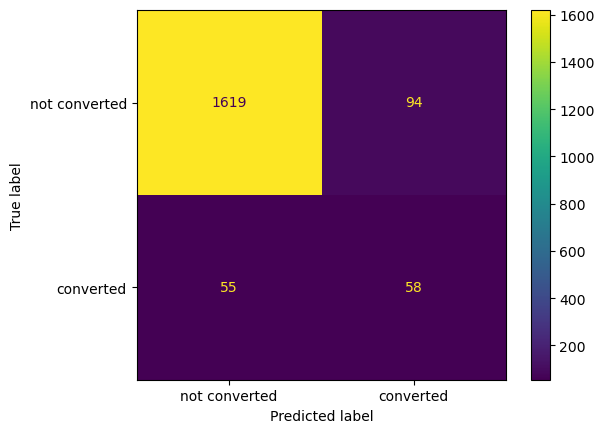

In [8]:
y_pred = np.where(model.predict(df_test[all_features]) > 0.5, 1, 0)
cm = confusion_matrix(df_test['converted_user'].fillna(False), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not converted', 'converted'])
print(f"model score {fbeta_score(df_test['converted_user'].fillna(False), y_pred, beta=2)}")
print(classification_report(df_test['converted_user'].fillna(False), y_pred))
disp.plot()

One of Snowplow's best features is its ability to accurately measure time engaged and scroll depth on a page by aggregating *[page ping](https://docs.snowplow.io/docs/collecting-data/collecting-from-own-applications/javascript-trackers/javascript-tracker/javascript-tracker-v2/tracking-specific-events/#activity-tracking-page-pings)* events. From the feature importance plot below you can see the power of these engagement metrics in predicting conversion.


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

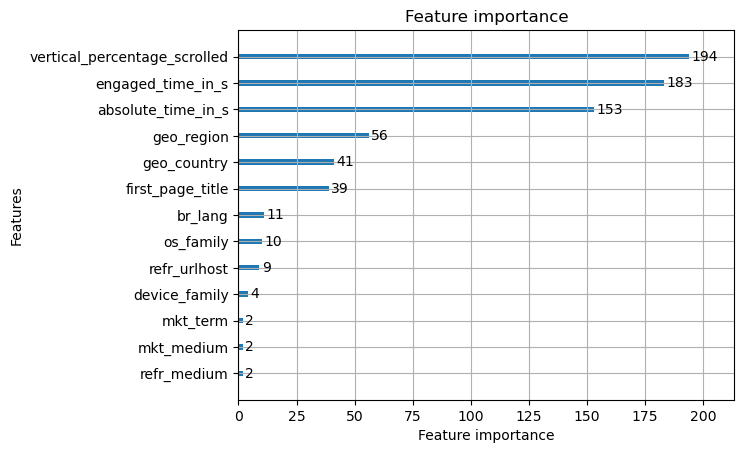

In [9]:
lgb.plot_importance(model.steps[1][1], max_num_features=15)

### Create Snowflake Stored Procedure

First create a Python function that can be saved as a Stored Procedure running in Snowflake by combining all the preparation and training steps you've worked through above.

Also include a step to save the model in a Snowflake stage so it can be easily loaded by a Snowflake UDF later.

In [10]:
def train_propensity_to_convert_model(session: Session) -> str:

  import lightgbm as lgb
  from imblearn.over_sampling import SMOTENC
  import dill
  import pandas as pd
  import numpy as np

  # Prepare data
  user_features = session.table('FIRST_TOUCH_USER_FEATURES')
  df  = pd.DataFrame(user_features.collect())
  df.columns = map(str.lower, df.columns)

  ref_cols = ['refr_urlhost', 'refr_medium']
  mkt_cols = ['mkt_medium', 'mkt_source', 'mkt_term', 'mkt_campaign']
  geo_cols = ['geo_country', 'geo_region', 'br_lang']
  dev_cols = ['device_family', 'os_family']
  url_cols = ['first_page_title']
  engagement_cols = ['engaged_time_in_s', 'absolute_time_in_s', 'vertical_percentage_scrolled']

  discrete_col = ref_cols + mkt_cols + geo_cols + dev_cols + url_cols
  continues_col = engagement_cols
  all_features = discrete_col + continues_col

  # Input missing data
  for col in discrete_col:
    df[col].fillna('N/A', inplace=True)
  for col in continues_col:
    df[col].fillna(df[col].mean(), inplace=True)

  # Reduce number of categorical features so `SMOTENC` doesn't run out of memory.
  class TakeTopK(BaseEstimator, TransformerMixin):
    def __init__(self, k=20):
      self.largest_cat = {}
      self.k = k

    def fit(self, X, y=None):
      for col in discrete_col:
        self.largest_cat[col] = df[col].value_counts().nlargest(self.k).index
      return self

    def transform(self, X, y=None):
      Xt = pd.DataFrame()
      for col in discrete_col:
        Xt[col] = pd.Series(np.where(X[col].isin(self.largest_cat[col]), X[col], 'Other'), dtype='category')
      Xt[continues_col] = X[continues_col].astype(float)
      return Xt

  # Create train and test data sets
  cat_index = [ pd.Index(all_features).get_loc(col) for col in discrete_col ]
  df_train, df_test = df.iloc[:df.shape[0]//10*8,:], df.iloc[df.shape[0]//10*8:,:]
  smote_nc = SMOTENC(categorical_features=cat_index, k_neighbors=5,  random_state=0)
  topk = TakeTopK(50)
  X_res, y_res = smote_nc.fit_resample(topk.fit_transform(df_train[all_features]), df_train.converted_user)

  # Train model
  lgbm = Pipeline([('top_20', TakeTopK(50)), ('clf', lgb.LGBMClassifier())])

  search_space = {
    'clf__max_depth': [3, 4, 5, 6, 7],
    'clf__objective': ['binary'],
    'clf__metric': ['binary_logloss'],
    'clf__n_estimators': [10, 50, 100, 200],
    'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'clf__num_leaves': [20, 30],
    'clf__min_child_samples': [5, 10, 15]
  }

  scorer = make_scorer(fbeta_score, beta=2, pos_label=True)

  gscv = GridSearchCV(estimator=lgbm, param_grid=search_space, cv=5, scoring=scorer, n_jobs=-1)
  gscv.fit(X_res, y_res.astype(int))

  # log the best model information
  model = gscv.best_estimator_

  # Upload trained model to a stage
  model_file = os.path.join('/tmp', 'model.joblib')
  with open(model_file, "wb") as dill_file:
    dill.dump(model, dill_file)
  session.file.put(model_file, "@ml_models", overwrite=True)

  # Return model F2 score on train and test data and show best model parameters
  y_pred = np.where(model.predict(df_test[all_features]) > 0.5, 1, 0)
  return {
    'F2 score on train': gscv.best_score_,
    'F2 score on test': fbeta_score(df_test['converted_user'].fillna(False), y_pred, beta=2),
    'Best parameters': gscv.best_params_
  }


Let's test this function runs as expected.

In [11]:
train_propensity_to_convert_model(session)

{'F2 score on train': 0.8806674943058214,
 'F2 score on test': 0.46666666666666673,
 'Best parameters': {'clf__learning_rate': 1.0,
  'clf__max_depth': 6,
  'clf__metric': 'binary_logloss',
  'clf__min_child_samples': 5,
  'clf__n_estimators': 100,
  'clf__num_leaves': 30,
  'clf__objective': 'binary'}}

When ready you can register this model training Python function as a Snowpark Python Stored Procedure.

At the time of writing this accelerator the imblanced-learn package is not supported in the [Snowflake conda channel](https://repo.anaconda.com/pkgs/snowflake/) so you have to import it.

In [12]:
import imblearn
imblearn_path = imblearn.__path__[0]

session.sproc.register(
  func=train_propensity_to_convert_model,
  name="TRAIN_PROPENSITY_TO_CONVERT_MODEL",
  packages=['snowflake-snowpark-python','scikit-learn', 'lightgbm', 'dill'],
  imports=[imblearn_path],
  is_permanent=True,
  stage_location="@SPROC_STAGE",
  replace=True
)

You can now call this stored procedure by executing the following command:
```sql
CALL TRAIN_PROPENSITY_TO_CONVERT_MODEL();
```